In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mbtrack2 import CavityResonator, BeamLoadingEquilibrium
from machine_data import v2366_v3

def get_active_cavity_params(ring):
    I0 = 0.5
    xi=1.1
    Vc=1.7e6
    
    # ring = v2366_v3(HC_power=0, IDs=id_state, V_RF=Vc)
    
    # HC = CavityResonator(ring, m=4, Rs=60*31e3, Q=31e3, QL=31e3, detune=1e6, Ncav=1)
    # HC = CavityResonator(ring, m=4, Rs=45*36e3, Q=36e3, QL=36e3, detune=1e6, Ncav=1)
    HC = CavityResonator(ring, m=4, Rs=2.358e6, Q=36e3, QL=36e3, detune=1e6, Ncav=1)
    
    HC.Vg = 0
    HC.theta_g = 0
    
    HC_det = I0*HC.Rs/HC.Q*ring.f1/Vc*HC.m**2/xi
    print(HC_det)
    HC.detune = HC_det
    
    delta = HC.Vb(I0) * np.cos(HC.psi)
    
    MC = CavityResonator(ring, m=1, Rs=5e6, Q=35.7e3, QL=6e3, detune=1e6, Ncav=4)
    
    MC.Vc = Vc
    MC.theta = np.arccos((ring.U0 + delta) / MC.Vc)
    MC.set_optimal_detune(I0)
    MC.set_generator(I0)
    
    BLE = BeamLoadingEquilibrium(ring, [MC, HC], I0, auto_set_MC_theta=True)
    BLE.beam_equilibrium(CM=True, plot=True)
    print(BLE.std_rho()/3e8*1e12)
    
    print("Form factors",BLE.F, BLE.PHI)
    
    for i, cavity in enumerate([MC, HC]):
        Vc_phasor = -1*cavity.Vb(I0) * BLE.F[i] * np.exp(1j*(cavity.psi - BLE.PHI[i])) + cavity.Vg * np.exp(1j*cavity.theta_g)
        cavity.Vc = np.abs(Vc_phasor)
        cavity.theta = np.angle(Vc_phasor)
    
# for i, cavity in enumerate([MC, HC]):
#     if i == 0:
#         print("MC")
#     elif i == 1:
#         print("HC")
    return MC.Vc, MC.theta, HC.Vc, HC.theta

In [2]:
import os
import numpy as np
from scipy.constants import c
from tqdm.notebook import tqdm
import h5py as hp
import matplotlib.pyplot as plt
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from mbtrack2.impedance.wakefield import WakeField
from mbtrack2.tracking import LongitudinalMap, SynchrotronRadiation, TransverseMap
from mbtrack2.tracking import Beam, Bunch, WakePotential
from mbtrack2.tracking import RFCavity, SynchrotronRadiation
from mbtrack2.tracking.monitors import BunchMonitor, WakePotentialMonitor
from mbtrack2.tracking.feedback import FIRDamper, ExponentialDamper
from machine_data.TDR2 import *
from machine_data.soleil import v2366, v2366_v2, v2366_v3
from SOLEILII_parameters.SOLEILII_TDR_parameters import *

def run_mbtrack2(
    n_turns=100_000,
    n_macroparticles=int(1e5),
    n_bin=100,
    bunch_current=1.2e-3,
    Qp_x=1.6,
    Qp_y=1.6,
    id_state="close",
    include_Zlong="False",
    harmonic_cavity="False",
    max_kick=0.0e+00,
    sc='False'
):
    ring2 = v2366_v3(IDs=id_state, V_RF = 1.7e6, HC_power=50e3)
    particle = Electron()
    chro = [Qp_x, Qp_y]
    ring = Synchrotron(
        h=ring2.h,
        optics=ring2.optics,
        particle=particle,
        L=ring2.L,
        E0=ring2.E0,
        ac=ring2.ac,
        U0=ring2.U0,
        tau=ring2.tau,
        emit=ring2.emit,
        tune=ring2.tune,
        sigma_delta=ring2.sigma_delta,
        sigma_0=ring2.sigma_0,
        chro=chro,
    )
    mybunch = Bunch(
        ring, mp_number=n_macroparticles, current=bunch_current, track_alive=False
    )
    np.random.seed(42)
    mybunch.init_gaussian()
    stdx, stdy = np.std(mybunch['x']), np.std(mybunch['y'])
    monitor_filename = "monitors(n_mp={:.1e},n_turns={:.1e},n_bin={:},bunch_current={:.1e},Qp_x={:.2f},Qp_y={:.2f},id_state={:},Zlong={:},cavity={:},max_kick={:.1e},sc={:})".format(
        n_macroparticles,
        n_turns,
        n_bin,
        bunch_current,
        Qp_x,
        Qp_y,
        id_state,
        include_Zlong,
        harmonic_cavity,
        max_kick,
        sc
    )
    bunch_monitor = BunchMonitor(
        0,
        save_every=1,
        buffer_size=1000,
        total_size=n_turns,
        file_name=monitor_filename,
        mpi_mode=False,
    )
    long_map = LongitudinalMap(ring)
    if harmonic_cavity == "False":
        rf = RFCavity(ring, m=1, Vc=V_RF, theta=np.arccos(ring.U0 / V_RF))
    if harmonic_cavity == "True":
        V_RF_main, theta_main, V_RF_harmonic, theta_harmonic = get_active_cavity_params(ring)
        # theta_main = 1.2753602707269827
        # theta_harmonic = -1.7210480862530364
        # V_RF_main = 1.78786174535864e6
        # V_RF_harmonic = 0.4292124905802067e6
        main_rf = RFCavity(ring, m=1, Vc=V_RF_main, theta=theta_main)
        harmonic_rf = RFCavity(ring, m=4, Vc=V_RF_harmonic, theta=theta_harmonic)
    sr = SynchrotronRadiation(ring, switch=[1, 1, 1])
    trans_map = TransverseMap(ring)
    wakemodel = load_TDR2_wf(version=("TDR2.1_ID" + id_state))
    wakefield_long = WakePotential(ring, wakefield=WakeField([wakemodel.Wlong]), n_bin=n_bin)

    tracking_elements = [trans_map, long_map, sr, bunch_monitor]
    if harmonic_cavity == "True":
        print("Harmonic cavity is on.")
        tracking_elements.append(main_rf)
        tracking_elements.append(harmonic_rf)
        
    else:
        print("Harmonic cavity is off.")
        tracking_elements.append(rf)
    if include_Zlong:
        print("Longitudinal impedance included.")
        tracking_elements.append(wakefield_long)

    monitor_count=0
    for i in tqdm(range(n_turns)):
        for el in tracking_elements:
            el.track(mybunch)

In [3]:
v2366_v3?

Signature: v2366_v3(IDs='open', V_RF=1700000.0, HC_power=50000.0)
Docstring:
TDR lattice v2366 w/ RF parameters from November 2023 RF budget.
Natural emittance and 1% coupling because of Synchrotron Radiation 
implementation.

Parameters
----------
IDs : {"open","close","close_phase2", "close_phase2_margin"}, optional
    ID configuration to consider. 
    "open": bare lattice
    "close": ID phase 1
    "close_phase2": ID phase 2
    "close_phase2_margin": ID phase 2 + 15 % margin
    The default is "open".
V_RF : float, optional
    Total RF voltage in [V]. 
    The default is 1.7e6.
HC_power : float, optional
    HC dissipated power at 500 mA.
    Should be taken as 0 if the HC dissipation is taken into account in the 
    simulation, for example by simulating the HC as a CavityResonator.
    The default is 50e3.

Returns
-------
ring : Synchrotron object
    TDR lattice v2366_v3.
File:      ~/scripts/impedance_calculation/machine_data/soleil.py
Type:      function


98727.29956520982
64.90016893266072
Form factors [0.98969272 0.84164351] [-4.76613278e-05 -3.40665001e-03]
Harmonic cavity is on.


  0%|          | 0/10000 [00:00<?, ?it/s]

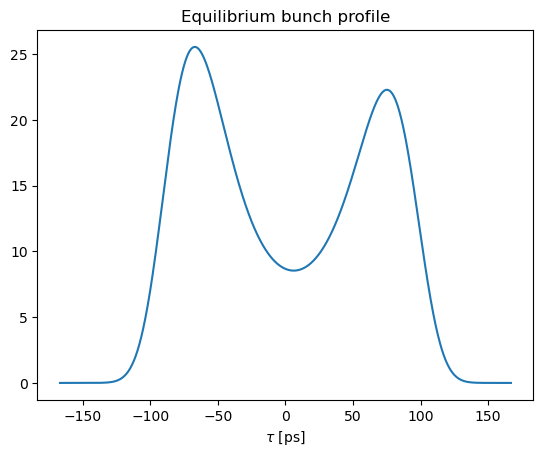

In [4]:
if __name__ == "__main__":
    run_mbtrack2(
        n_turns=10_000,
        n_macroparticles=100_000,
        n_bin=100,
        bunch_current=1.2e-3,
        Qp_x=0,
        Qp_y=0,
        id_state='close',
        include_Zlong=False,
        harmonic_cavity='True',
        max_kick=0,
        sc='False'
    )

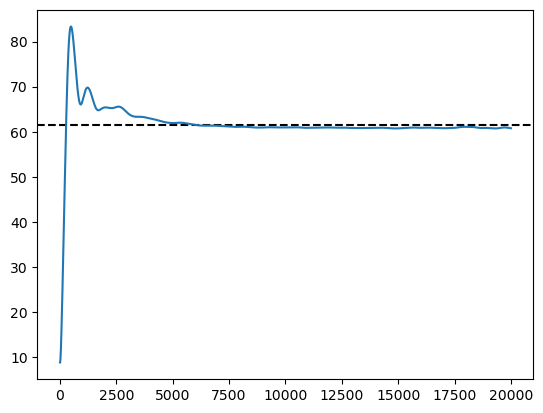

In [5]:
%matplotlib inline
import h5py as hp
f = hp.File('monitors(n_mp=1.0e+05,n_turns=2.0e+04,n_bin=100,bunch_current=1.2e-03,Qp_x=0.00,Qp_y=0.00,id_state=close,Zlong=True,cavity=True,max_kick=0.0e+00,sc=False).hdf5')
sig_z = f['BunchData_0']['std'][4,:]
f.close()
plt.axhline(61.4, ls='dashed', color='black')
plt.plot(sig_z*1e12)